**This notebook introduces how to train a conditional VAE model from scratch. <br/>**
We first use an encoder to compress the high-dimensional temperature data into latent vectors. Then, we incorporate CO2 & CH4 information into latent vectors, and use an decorder to reconstruct the global temperature map.

By Weiwei Zhan

Reference: https://towardsdatascience.com/variational-autoencoders-as-generative-models-with-keras-e0c79415a7eb

vary latent space - modify by Rong-Yu Gu, 10/10/23

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from glob import glob

import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
from utils import * 

from scipy.stats import norm

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

plt.rcParams['savefig.dpi'] = 400
plt.rcParams['font.size'] = 13
plt.rcParams["legend.frameon"] = False

2023-10-11 11:29:47.717946: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-11 11:29:47.760470: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
cwd = os.getcwd()
train_path = "gs://leap-persistent/jbusecke/data/climatebench/train_val/"
test_path = "gs://leap-persistent/jbusecke/data/climatebench/test/"

### 1. data preprocssing: prepare data for training & test sets

In [3]:
# Training set
train_files = ["historical", "ssp585", "ssp126", "ssp370","hist-GHG","hist-aer"]
X_train_xr, X_length  = prepare_predictor(train_files,train_path)
y_train_xr, y_length  = prepare_predictand(train_files,train_path)

# Test set
X_test_xr, _ = prepare_predictor('ssp245', data_path=test_path,time_reindex=False)
y_test_xr, _ = prepare_predictand('ssp245',data_path=test_path,time_reindex=False)


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

#### Data normalization

normalize the CO2 & CH4 time series

In [4]:
X_train_df = pd.DataFrame({"CO2": X_train_xr["CO2"].data,
                           "CH4": X_train_xr["CH4"].data
                          }, index=X_train_xr["CO2"].coords['time'].data)

X_test_df  = pd.DataFrame({"CO2": X_test_xr["CO2"].data,
                           "CH4": X_test_xr["CH4"].data
                          }, index=X_test_xr["CO2"].coords['time'].data)

# Normalization
mean, std = X_train_df.mean(), X_train_df.std()

X_train_df   = (X_train_df - mean)/std
X_test_df    = (X_test_df - mean)/std

X_train = X_train_df.to_numpy()
X_test = X_test_df.to_numpy()

print(X_train.shape,X_test.shape)

(753, 2) (86, 2)


normalize the 2-D temperature data 

In [5]:
var  = 'tas'
y_train = y_train_xr[var].data
y_test  = y_test_xr[var].data

mean = y_train.mean()
std  = y_train.std()

y_train = (y_train - mean)/std
y_test  = (y_test - mean)/std

y_train = np.expand_dims(y_train, -1).astype("float32") 
y_test  = np.expand_dims(y_test, -1).astype("float32") 

n_lat, n_lon = y_train.shape[1], y_train.shape[2]
print(y_train.shape,y_test.shape)

(753, 96, 144, 1) (86, 96, 144, 1)


### 2. Define the VAE architecture

![VAE_structure](https://drive.google.com/uc?export=view&id=1yVOTtfQTJEEijNWldOhNk3grO6QNT28E)


figure source: https://lilianweng.github.io/posts/2018-08-12-vae/

In [6]:
latent_dim = 2   # dimensions of the latent space
n_filters  = 32  # number of filters for the convolutional layers
n_neurons  = 64  # number of neurons for the Dense layers
activation = 'relu' # activation function
kernal_size = 4
learning_rate = 0.001
minibatch_size = 64
num_epochs     = 80

#### Build Encoder & Sampling for the latent vector

In [7]:
encoder_inputs = Input(shape=(n_lat, n_lon, 1)) # shape: (96,144,1)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(encoder_inputs) # shape: (48,72,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2D(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (12,18,32)
x = Flatten()(x) # shape: (6912,1)
x = Dense(n_neurons, activation=activation)(x) # shape: (16,1)


z_mean    = Dense(latent_dim, name="z_mean")(x) # shape: (2,1)
z_log_var = Dense(latent_dim, name="z_log_var")(x) # shape: (2,1)


def sample_latent_features(distribution):
    """
    This function takes previously calculated mean & variance, 
    and returns back a latent encoding vector. 
    """
    
    distribution_mean, distribution_variance = distribution
    batch_size = tf.shape(distribution_variance)[0]
    random = tf.keras.backend.random_normal(shape=(batch_size, tf.shape(distribution_variance)[1]))
    return distribution_mean + tf.exp(0.5 * distribution_variance) * random


z = Lambda(sample_latent_features)([z_mean, z_log_var])

encoder_model = Model(encoder_inputs, z, name="encoder")
encoder_model.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 48, 72, 32)   544         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 24, 36, 32)   16416       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 12, 18, 32)   16416       ['conv2d_1[0][0]']         

#### Build Decoder

Here we additionally include CO2 & CH4 as Decoder inputs (the `cond_input` variable)

In [8]:
decoder_input = Input(shape=(latent_dim,)) # shape: (2,1)
cond_input    = Input(shape=(X_train.shape[1],)) # shape: (2,1)
x = keras.layers.Concatenate(axis=1)([decoder_input]) # shape: (4,1)
x = Dense(12 * 18 * n_filters, activation=activation)(x) # shape: (6912,1)
x = Reshape((12, 18, n_filters))(x) # shape: (12,18,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (24,36,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (48,72,32)
x = Conv2DTranspose(n_filters, kernal_size, activation=activation, strides=2, padding="same")(x) # shape: (96,144,32)
decoder_output = Conv2DTranspose(1, kernal_size, activation="linear", padding="same")(x) # shape: (96,144,1)
decoder_model = Model([decoder_input,cond_input], decoder_output, name="decoder")
decoder_model.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 concatenate (Concatenate)      (None, 2)            0           ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 6912)         20736       ['concatenate[0][0]']            
                                                                                                  
 reshape (Reshape)              (None, 12, 18, 32)   0           ['dense_1[0][0]']                
                                                                                            

#### Build the conditional VAE

In [9]:
encoded = encoder_model(encoder_inputs)
decoded = decoder_model([encoded,cond_input])
autoencoder = Model([encoder_inputs,cond_input], decoded)

#### Define the loss function: reconstruction loss + KL loss

In [10]:
def get_loss(distribution_mean, distribution_variance):
    
    def get_reconstruction_loss(y_true, y_pred):
        reconstruction_loss = tf.keras.losses.mse(y_true, y_pred)
        reconstruction_loss_batch = tf.reduce_mean(reconstruction_loss)
        return reconstruction_loss_batch
    
    def get_kl_loss(distribution_mean, distribution_variance):
        kl_loss = 1 + distribution_variance - tf.square(distribution_mean) - tf.exp(distribution_variance)
        kl_loss_batch = tf.reduce_mean(kl_loss)
        return kl_loss_batch*(-0.5)
    
    def total_loss(y_true, y_pred):
        reconstruction_loss_batch = get_reconstruction_loss(y_true, y_pred) # *96*144
        kl_loss_batch = get_kl_loss(distribution_mean, distribution_variance) 
        # consider the reconstructure loss of all grids (96*144), not just the mean
        # without consider for all grids, global mean temperature would not be well predicted
        # the distribution of z may shift (not a normal distribution with mu=0, std=1)
        return reconstruction_loss_batch*96*144 + kl_loss_batch
    
    return total_loss

In [11]:
autoencoder.compile(loss=get_loss(z_mean,z_log_var), 
                    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 96, 144, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 encoder (Functional)           (None, 2)            476068      ['input_1[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 2)]          0           []                               
                                                                                                  
 decoder (Functional)           (None, 96, 144, 1)   70497       ['encoder[0][0]',            

### 3. Train the VAE model

this costs approximately ~1 hr

In [12]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

history = autoencoder.fit([y_train,X_train], y_train, 
                          epochs=num_epochs, 
                          batch_size=minibatch_size, 
                          validation_split=0.2)

Train on 602 samples, validate on 151 samples
Epoch 1/80


2023-10-11 11:36:05.495213: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-10-11 11:36:05.545658: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/conv2d_transpose_1/bias/v/Assign' id:1035 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d_transpose_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d_transpose_1/bias/v, training/Adam/conv2d_transpose_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


602/602 [==============================] - ETA: 0s - loss: 34571.1557

/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-10-11 11:36:20.944854: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:531 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/decoder_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


602/602 [==============================] - 17s 28ms/sample - loss: 34571.1557 - val_loss: 9220.8615
Epoch 2/80
602/602 [==============================] - 16s 27ms/sample - loss: 14236.5580 - val_loss: 9032.5454
Epoch 3/80
602/602 [==============================] - 16s 27ms/sample - loss: 14691.9195 - val_loss: 9248.3871
Epoch 4/80
602/602 [==============================] - 16s 27ms/sample - loss: 14378.4648 - val_loss: 9560.6470
Epoch 5/80
602/602 [==============================] - 16s 27ms/sample - loss: 13450.6214 - val_loss: 9759.4600
Epoch 6/80
602/602 [==============================] - 16s 27ms/sample - loss: 11275.4434 - val_loss: 9701.8717
Epoch 7/80
602/602 [==============================] - 16s 27ms/sample - loss: 8100.0031 - val_loss: 9123.0119
Epoch 8/80
602/602 [==============================] - 16s 27ms/sample - loss: 5914.5028 - val_loss: 8736.0471
Epoch 9/80
602/602 [==============================] - 16s 27ms/sample - loss: 4835.5228 - val_loss: 8511.7760
Epoch 10/80
602

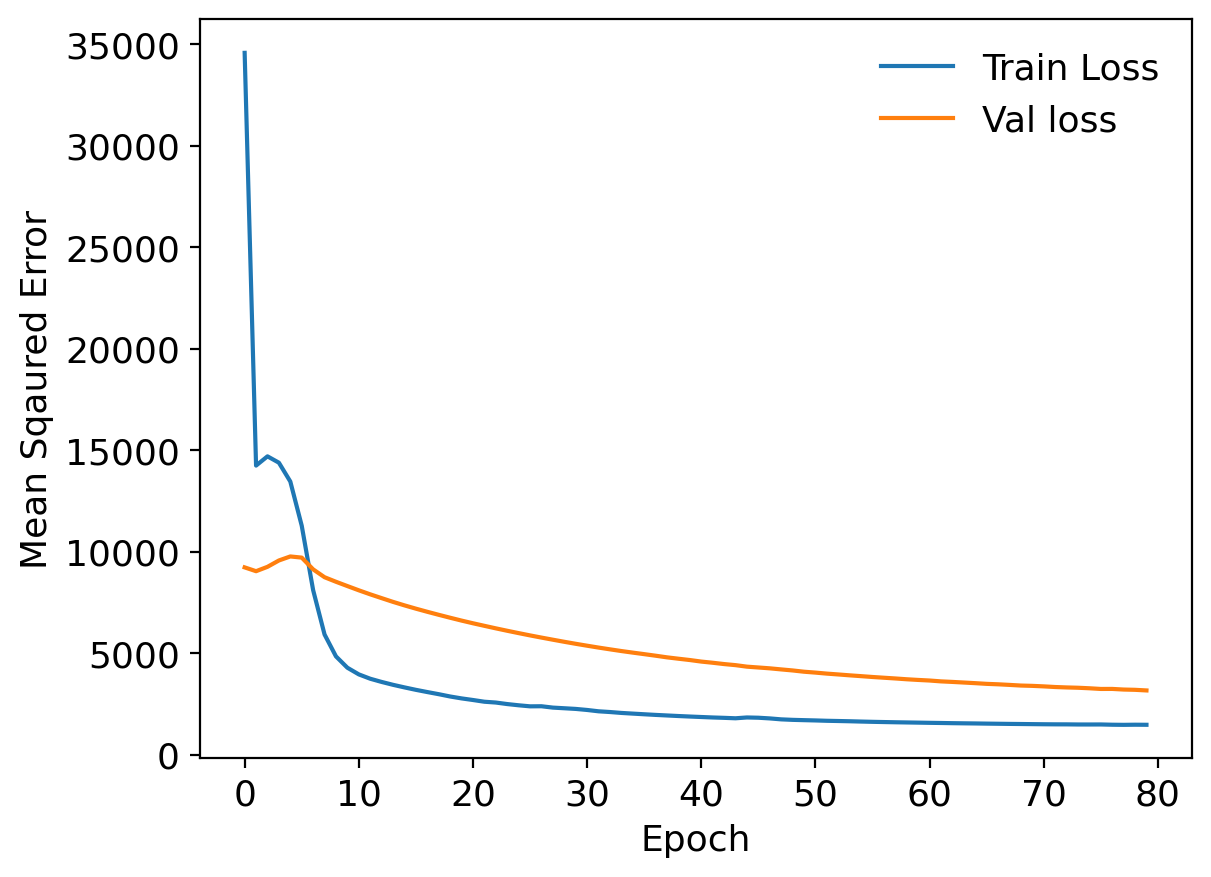

In [13]:
def plot_history(history):
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Sqaured Error')
    plt.plot(history.epoch, np.array(history.history['loss']),
           label='Train Loss')
    plt.plot(history.epoch, np.array(history.history['val_loss']),
           label = 'Val loss')
    plt.legend()
    
    
plot_history(history)

### 4. evaluate the model performance

Let's test the reconstruction capabilities of our VAE model on the test set.

In [14]:
z = encoder_model.predict(y_test)
y_test_pre = decoder_model.predict([z,X_test])

y_test_pre = y_test_pre*std + mean

y_test_pre = y_test_pre.reshape(y_test_pre.shape[0], 96, 144)
y_test_pre = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre)))

/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2023-10-11 11:57:36.879809: W tensorflow/c/c_api.cc:300] Operation '{name:'lambda/add' id:167 op device:{requested: '', assigned: ''} def:{{{node lambda/add}} = AddV2[T=DT_FLOAT, _has_manual_control_dependencies=true](z_mean/BiasAdd, lambda/mul_1)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2023-10-11 11:57:36.943202: W tensorflow/c/c_api.cc:300] Operation '{name:'conv2d_transpose_3/BiasAdd' id:354 op device:{requested: '', assigned: ''} def:{{{node conv2d_transpose_3/BiasAdd}} = BiasAdd[T=DT_FLOAT, _has_manual_control_dependencies=true, data_

Comparisons in terms of the spatial distribution

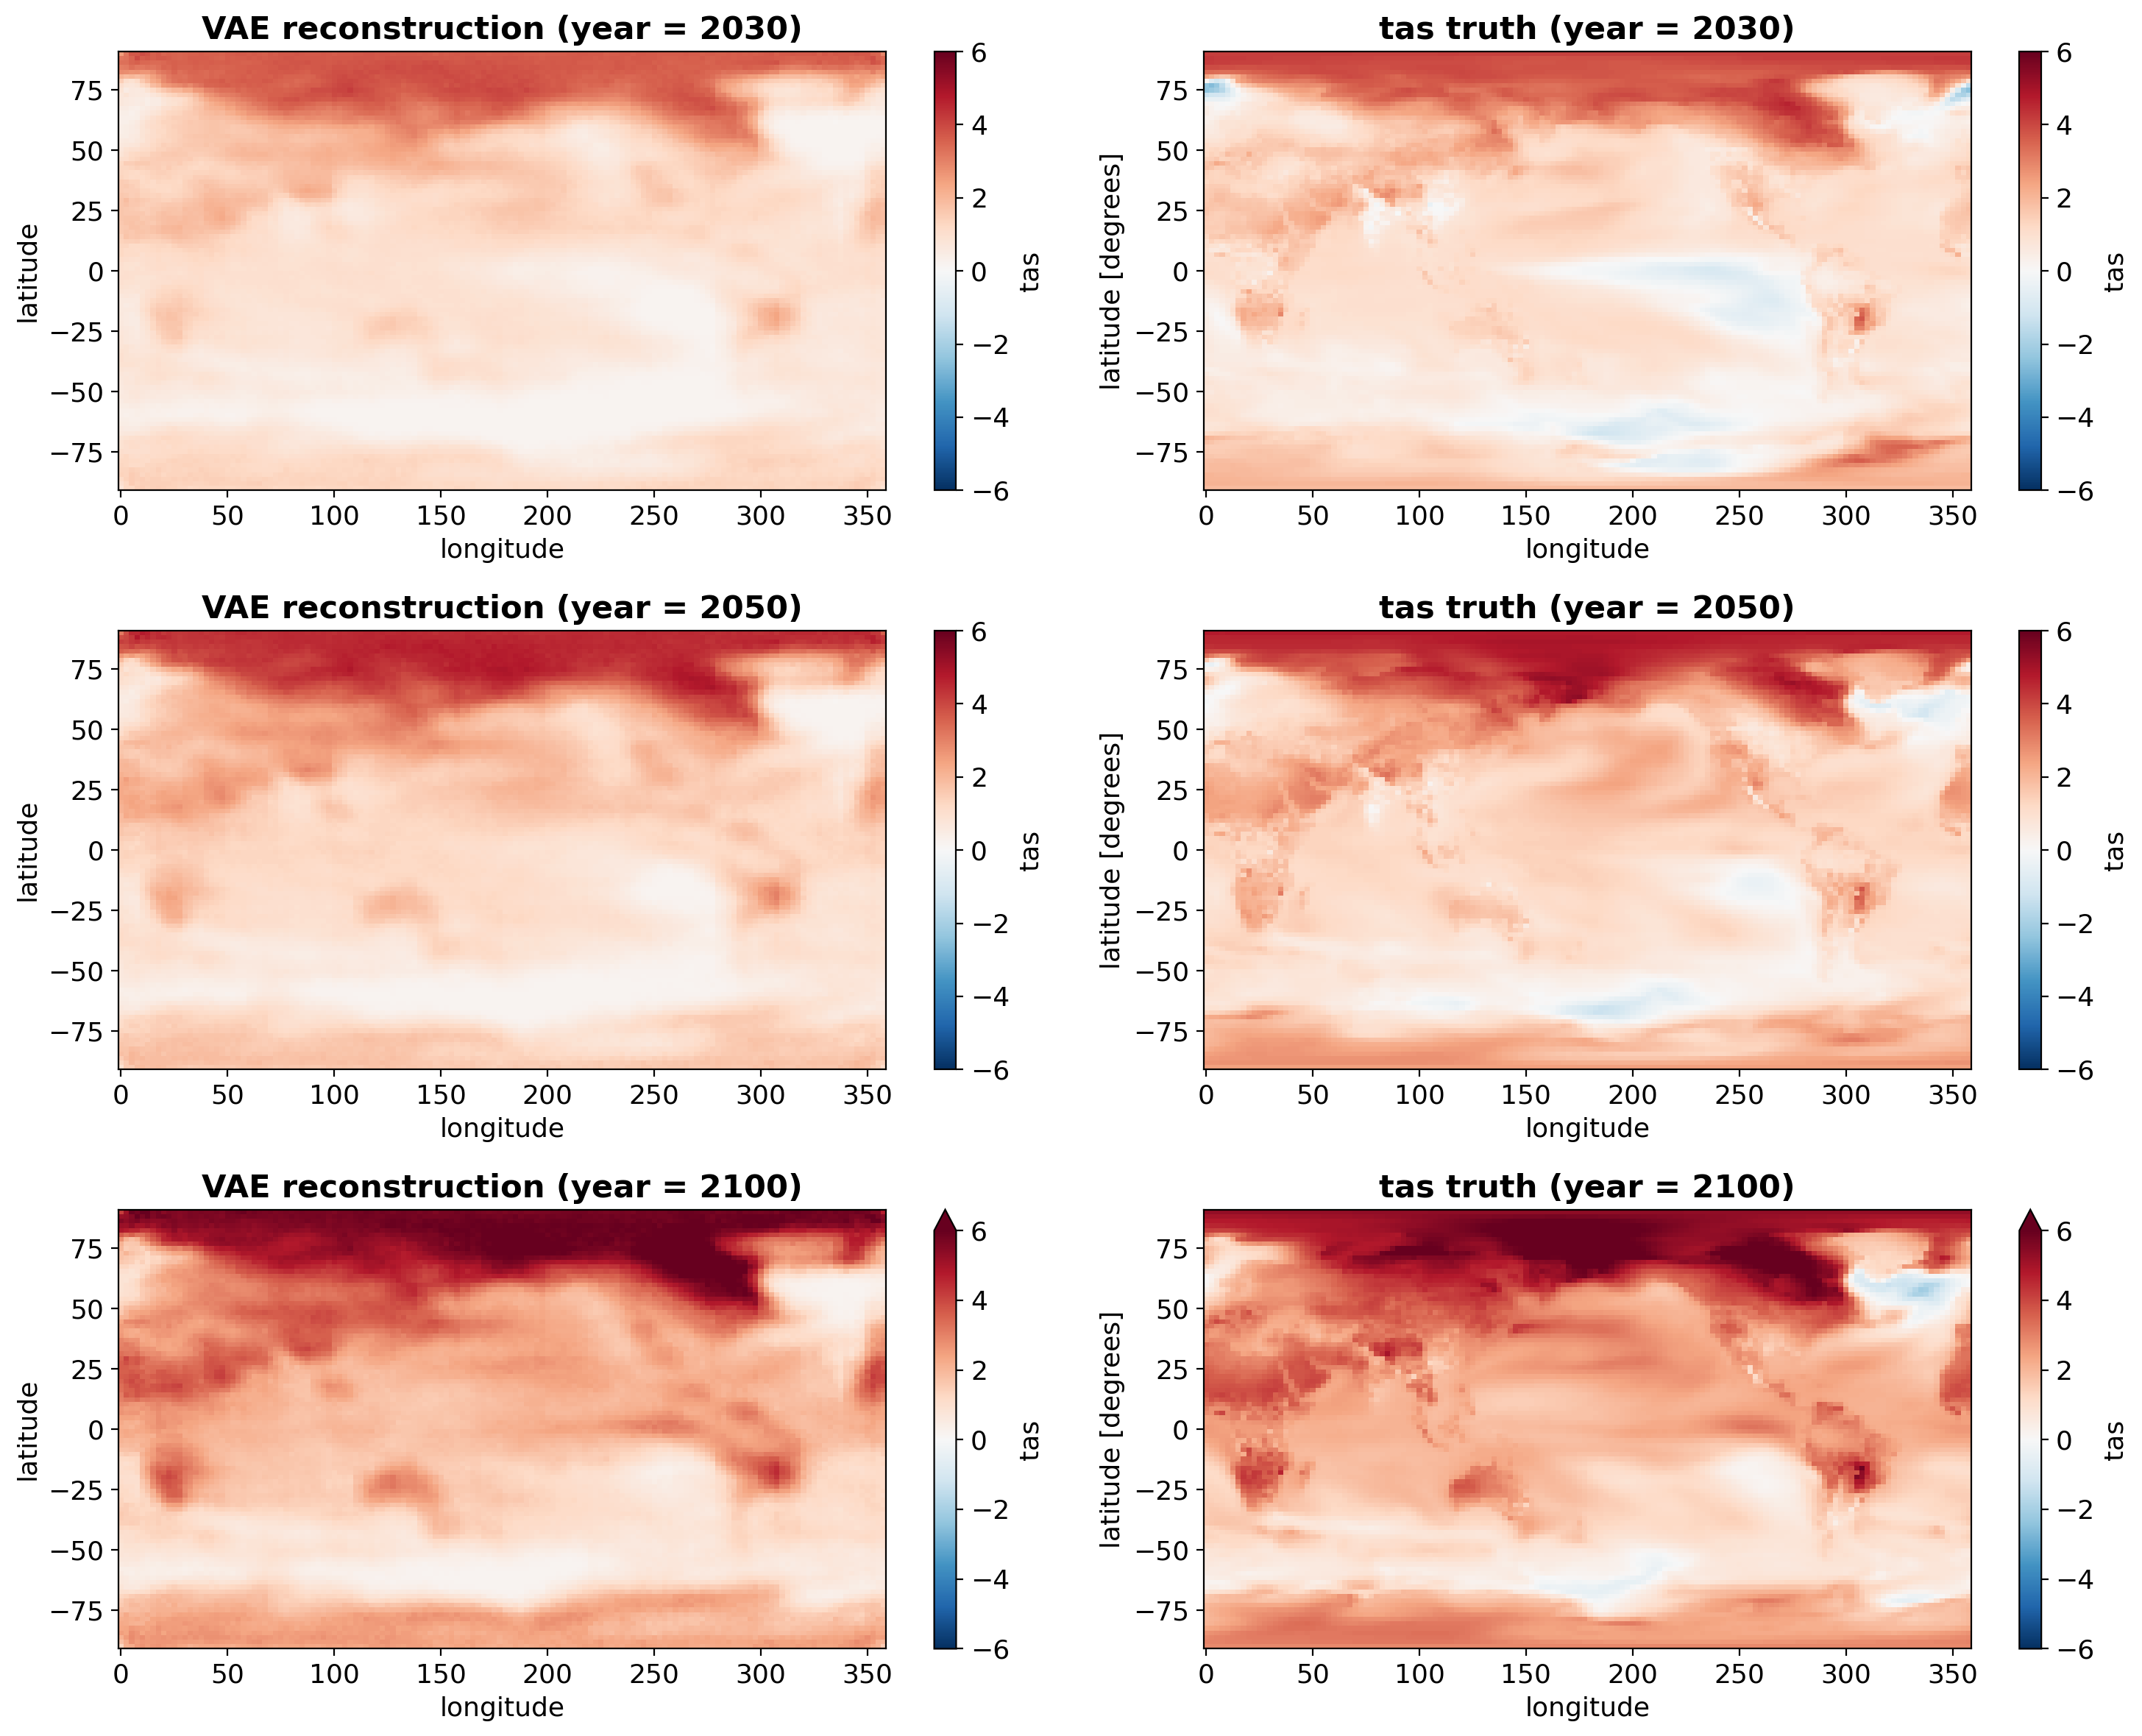

In [15]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=3)

yrs = [2030, 2050, 2100]
vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre.tas.sel(time=yrs[0]).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[0]).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[1]).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[1]).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)

y_test_pre.tas.sel(time=yrs[2]).plot(ax=axes[2,0], vmin=vmin, vmax=vmax,cmap=cmap)
y_test_xr.tas.sel(time=yrs[2]).plot(ax=axes[2,1], vmin=vmin, vmax=vmax,cmap=cmap)


for i, ax in enumerate(axes.flat):
    # left column: model prediction
    if i % 2 == 0:
        ax.set_title(f'VAE reconstruction (year = {yrs[i//2]})',fontweight='bold')
    # right column: truth tas from ssp245 simulations
    else:
        ax.set_title(f'tas truth (year = {yrs[i//2]})',fontweight='bold')
plt.tight_layout()

Comparisons in terms of the temporal variability (under the ssp245 scenario)

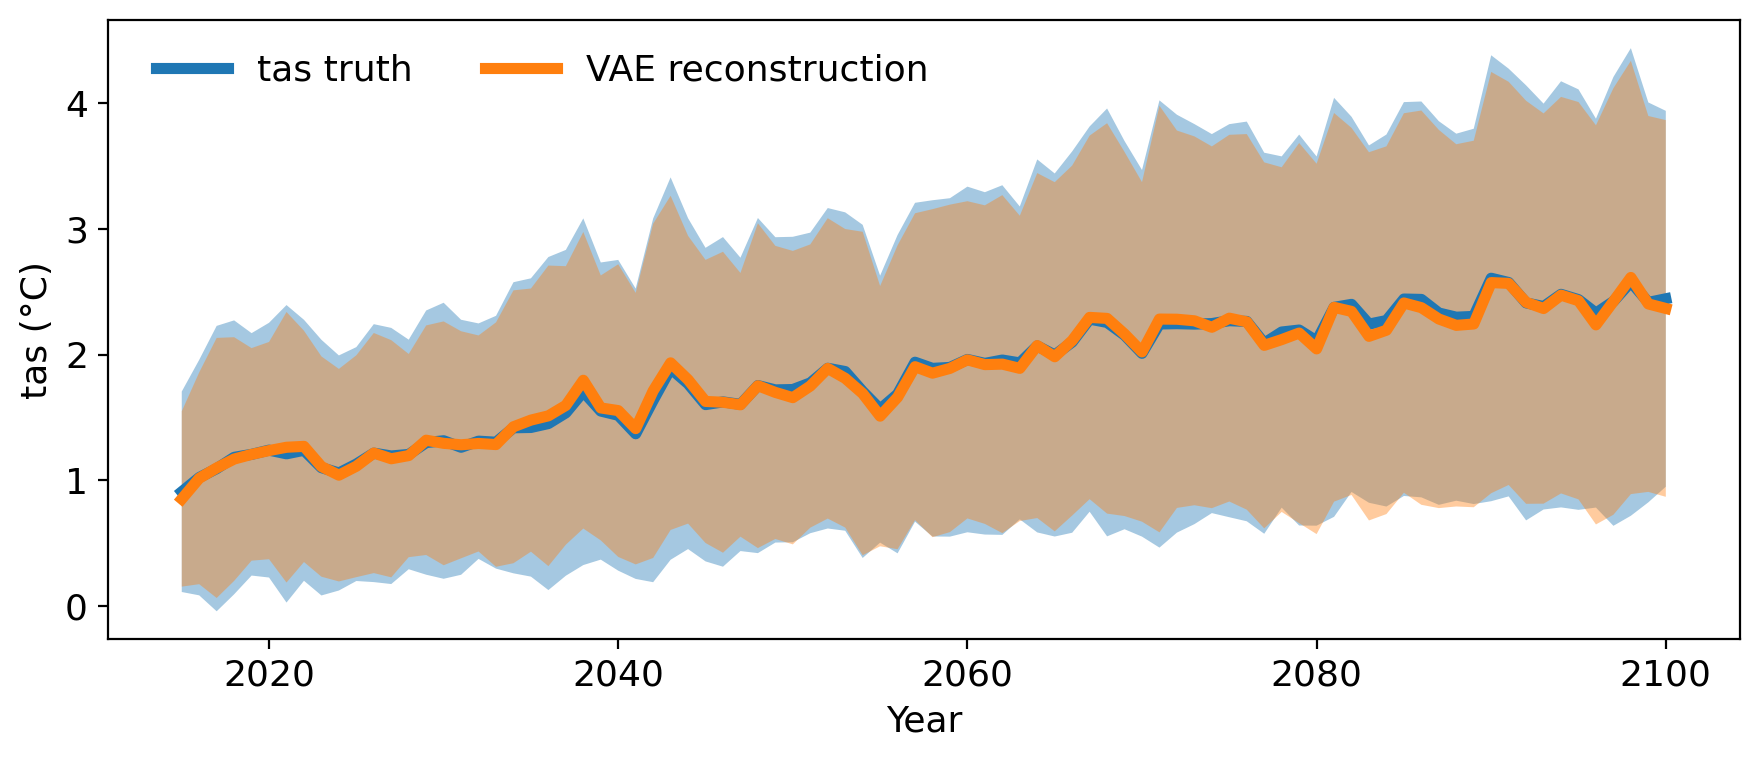

In [16]:
fig, ax = plt.subplots(figsize=(9,4))

yr,mean_truth = mean_std_plot(y_test_xr['tas'],color='tab:blue',label='tas truth',ax=ax)
yr,mean_pre   = mean_std_plot(y_test_pre['tas'],color='tab:orange',label='VAE reconstruction',ax=ax)

ax.set_xlabel('Year')
ax.set_ylabel('tas (°C)')


fig.legend(loc='upper left',bbox_to_anchor=(0.08,0.95),ncol=2)


plt.tight_layout()

### 5. check how the latent space affect model output

Here we display a simple way to show how the latent space affect model output. We vary z in each dimension respectively and pass it through the decoder, which means the decoder is conditioned on a different z value. Then, we plot and compare the model output between the original z and a varied z.

First, let's look at the distribution of z in each dimension.


shape of latent space =  (86, 2)
latent space for the first 5 years of test data =  [[ 0.9787014 -3.7084115]
 [ 1.5596788 -4.707479 ]
 [ 4.1869574 -5.8682823]
 [ 1.9321337 -5.581466 ]
 [-0.9326011 -4.7922964]]


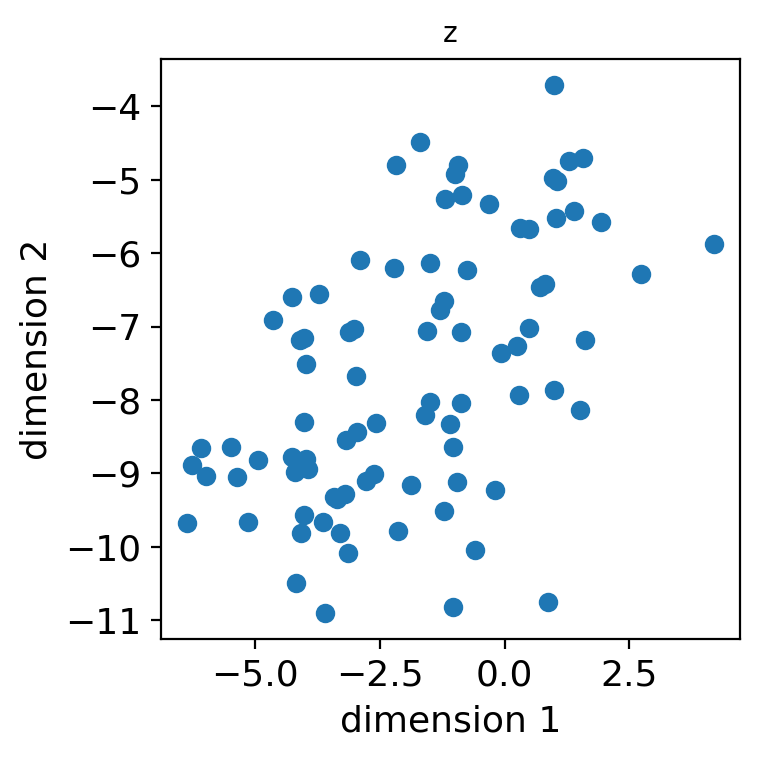

In [17]:
### visualize the latent space (z)
print("shape of latent space = ", np.shape(z)) # shape of z = (test_years, latent_dim)
print("latent space for the first 5 years of test data = ", z[0:5,:])

# fit a normal distribution on z
mu_fit1, std_fit1 = norm.fit(z[:,0])
mu_fit2, std_fit2 = norm.fit(z[:,1])

## plot z
fig, ax = plt.subplots(figsize=(4,4))

plt.scatter(z[:,0],z[:,1])

plt.title("z", fontsize=10)
plt.xlabel('dimension 1')
plt.ylabel('dimension 2')
plt.tight_layout()



Then, we vary z as a arbitary value in each dimension respectively. In this example, we only implement a varied z in the first year of the output (year = 2015).

In [26]:
### varying latent space
# dimension 1
z1 = np.copy(z)
z1[[0],0] = -2 # vary latent space dimension 1 at year 2015 (first year of the test data)
print("original z[[0],0] = ", np.round(z[[0],0], 4), ", new z[[0],0] =", np.round(z1[[0],0],4))

# pass the new z to the decoder
y_test_pre_varyz1 = decoder_model.predict([z1,X_test])

y_test_pre_varyz1 = y_test_pre_varyz1*std + mean

# save the output as an xarray
y_test_pre_varyz1 = y_test_pre_varyz1.reshape(y_test_pre_varyz1.shape[0], 96, 144)
y_test_pre_varyz1 = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz1)))


# dimension 2
z2 = np.copy(z)
z2[[0],1] = -1 # vary latent space dimension 2 at year 2015
print("original z[[0],1] = ", np.round(z[[0],1], 4), ", new z[[0],1] =", np.round(z2[[0],1],4))

y_test_pre_varyz2 = decoder_model.predict([z2,X_test])

y_test_pre_varyz2 = y_test_pre_varyz2*std + mean

y_test_pre_varyz2 = y_test_pre_varyz2.reshape(y_test_pre_varyz2.shape[0], 96, 144)
y_test_pre_varyz2 = xr.Dataset(coords={'time': y_test_xr.time.values, 
                               'latitude': y_test_xr.latitude.values, 
                               'longitude': y_test_xr.longitude.values},
                       data_vars=dict(tas=(['time', 'latitude', 'longitude'], y_test_pre_varyz2)))

original z[[0],0] =  [0.9787] , new z[[0],0] = [-2.]
original z[[0],1] =  [-3.7084] , new z[[0],1] = [-1.]


Compare the varied z output with the original output

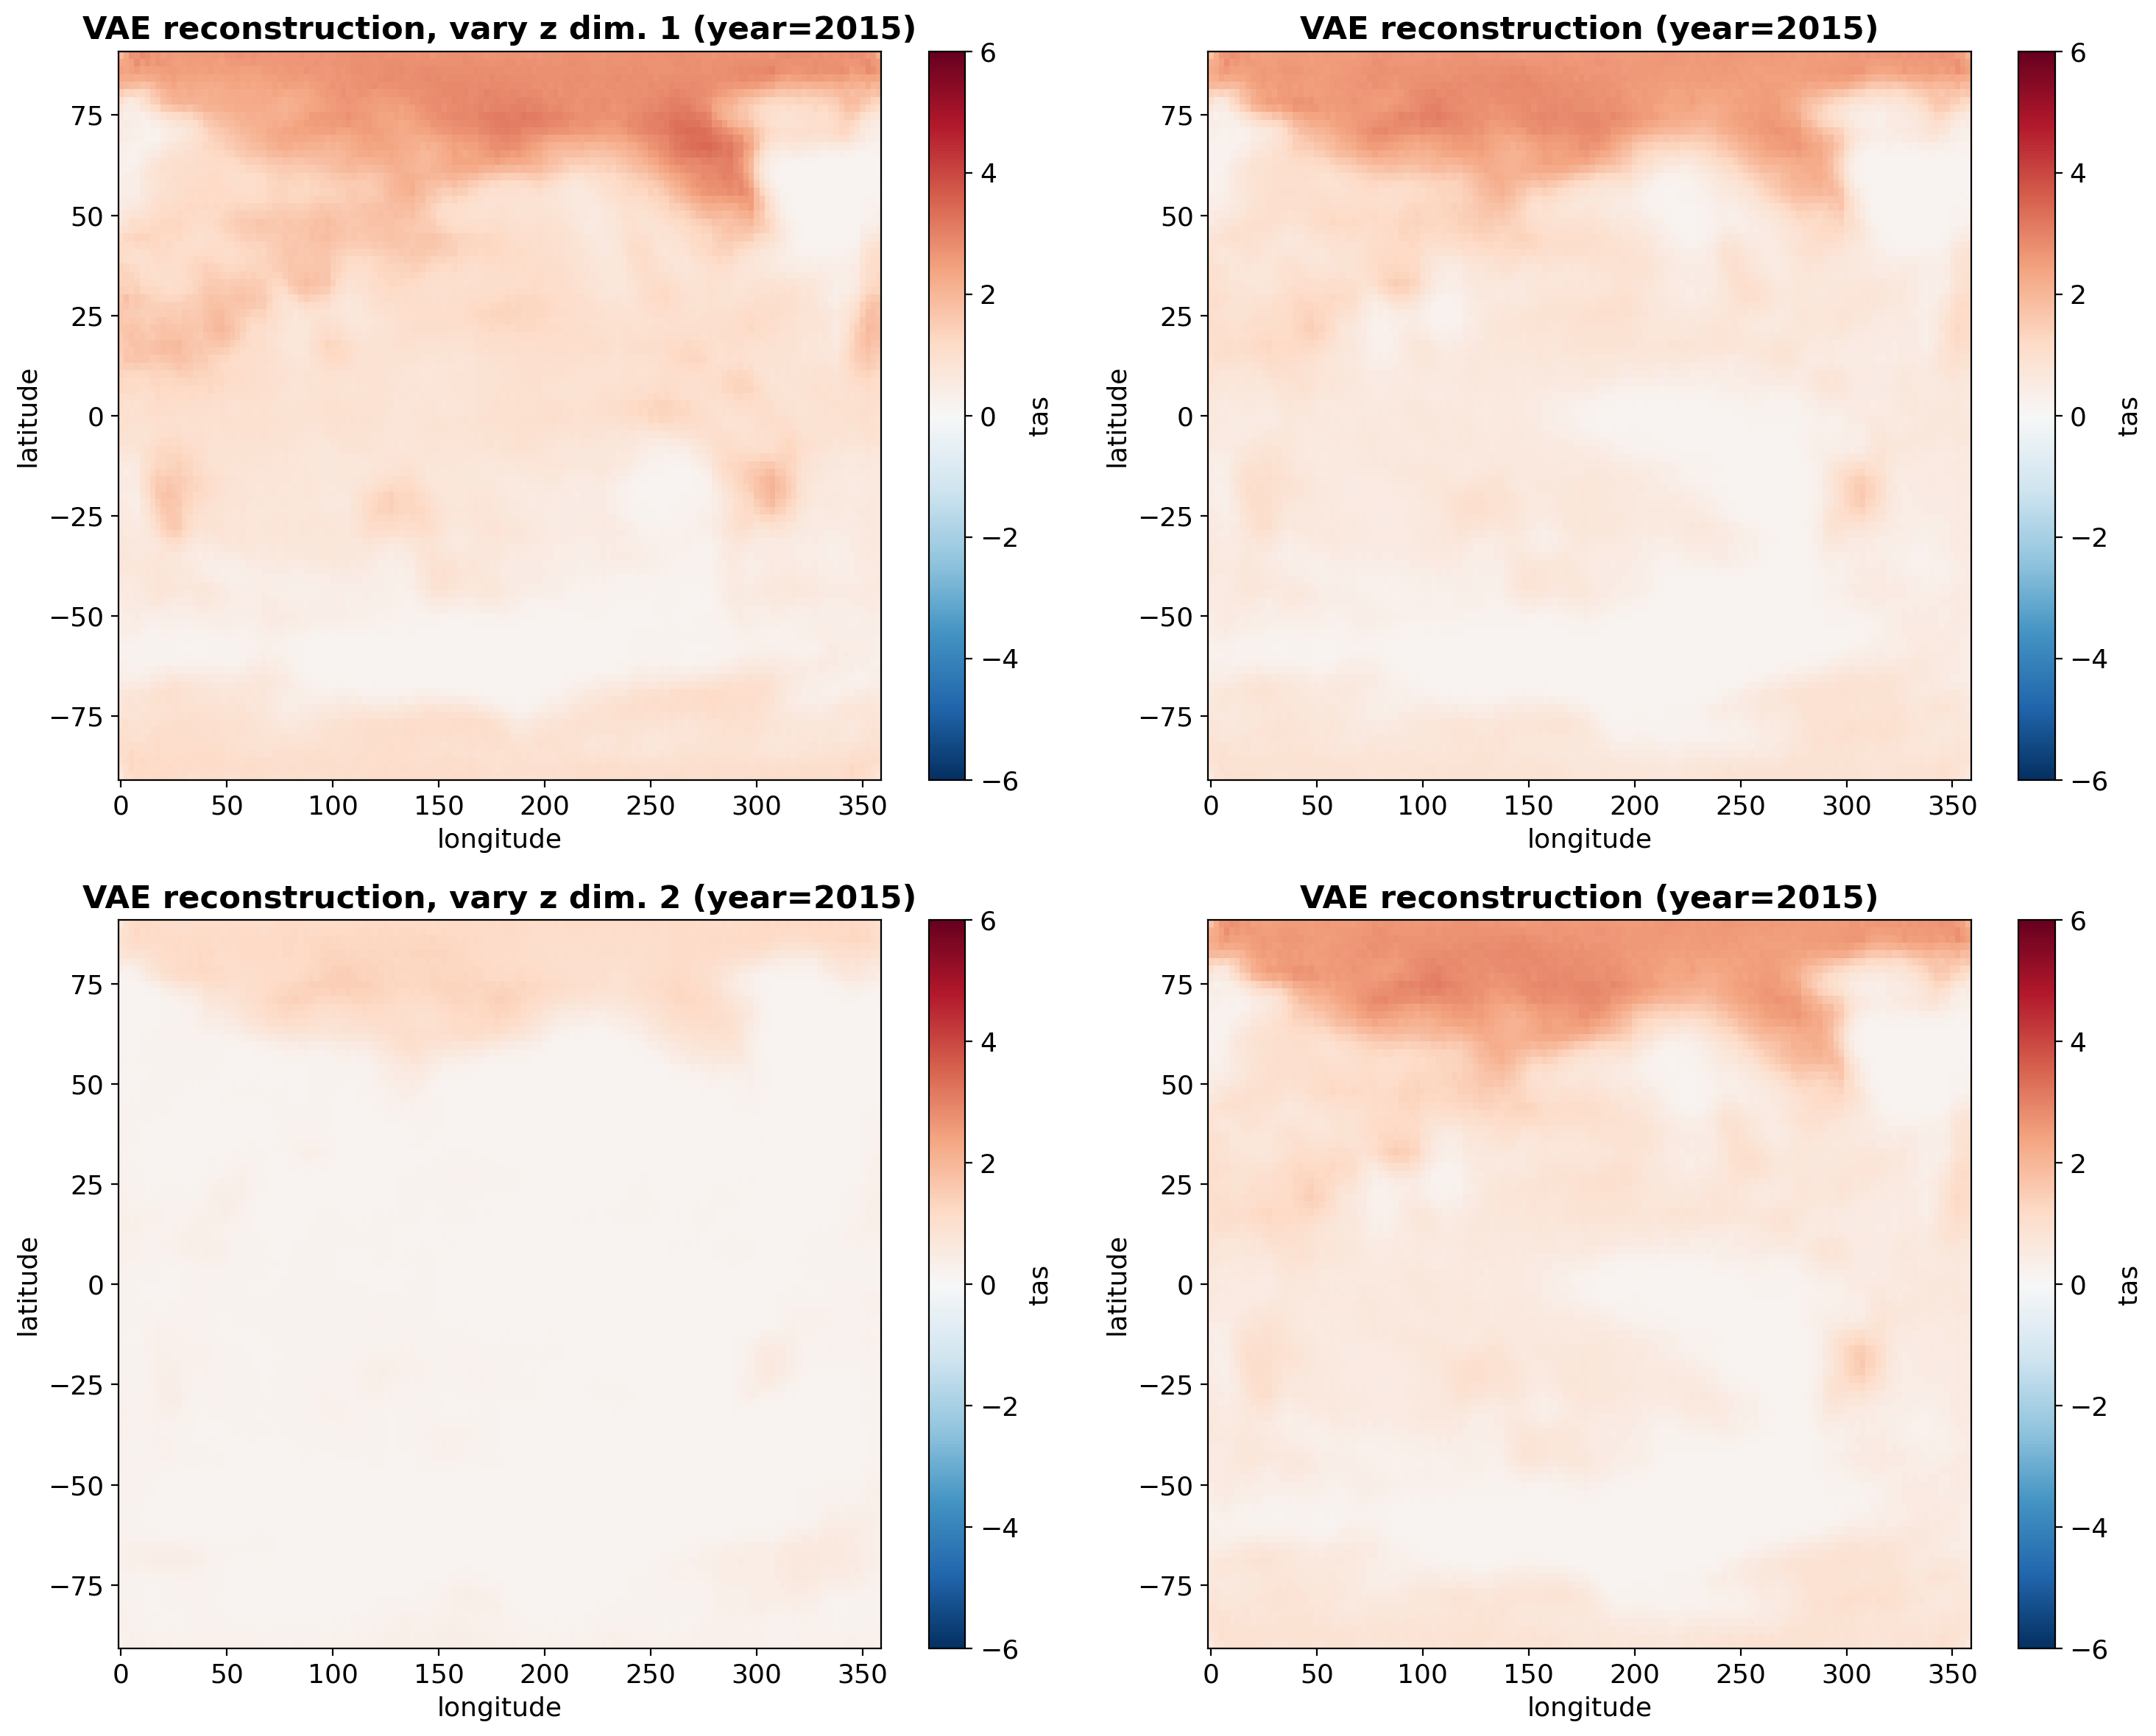

In [27]:
fig, axes = plt.subplots(figsize=(15,12),ncols=2,nrows=2)

vmin, vmax    = -6, 6
cmap = 'RdBu_r'
y_test_pre_varyz1.tas.sel(time=2015).plot(ax=axes[0,0], vmin=vmin, vmax=vmax,cmap=cmap)
axes[0,0].set_title(f'VAE reconstruction, vary z dim. 1 (year=2015)',fontweight='bold')

y_test_pre.tas.sel(time=2015).plot(ax=axes[0,1], vmin=vmin, vmax=vmax,cmap=cmap)
axes[0,1].set_title(f'VAE reconstruction (year=2015)',fontweight='bold')

y_test_pre_varyz2.tas.sel(time=2015).plot(ax=axes[1,0], vmin=vmin, vmax=vmax,cmap=cmap)
axes[1,0].set_title(f'VAE reconstruction, vary z dim. 2 (year=2015)',fontweight='bold')

y_test_pre.tas.sel(time=2015).plot(ax=axes[1,1], vmin=vmin, vmax=vmax,cmap=cmap)
axes[1,1].set_title(f'VAE reconstruction (year=2015)',fontweight='bold')

plt.tight_layout()